# Segmetation evaluation preparation

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import math
import scipy.misc
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev
from tqdm import tqdm

annot_path = '/home/phantom/projects/vision/phantomnet/datasets/phantom/Annotations'

seg_bench_root = '/media/phantom/World/phantom_benchmark'
img_path = os.path.join(seg_bench_root, 'images')
out_gt_path = os.path.join(seg_bench_root, 'segmentation', 'gt')
out_vs_path = os.path.join(seg_bench_root, 'segmentation', 'gt_vs')

## Marker size

Closer road markers should be larger than further markers. Simply assume they depends on y-values.

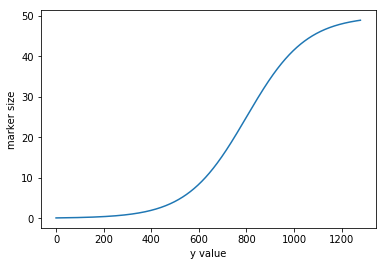

In [4]:
SHIFT = 800
MAXRADIUS = 50
def get_marker_size(x):
    """
    basically, based on sigmoid function.
    - ALPHA controls slope
    - at SHIFT, sigmoid value is 0.5. Therefore half size. 
    """
    x -= SHIFT
    ALPHA = 0.008
    return 1. / (1. + math.exp(- 0.008 * x)) * MAXRADIUS

y = np.arange(0, 1280).astype(np.float32)
plt.plot(y, [get_marker_size(v) for v in y])
plt.xlabel('y value')
plt.ylabel('marker size')
plt.show()

## Sample annotation

100%|██████████| 3/3 [00:00<00:00, 22.42it/s]


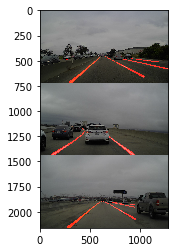

In [5]:
def clean_data(xs, ys):
    """
    delete duplicate points. make strictly increas
    """
#     idx = np.argsort(xs); xs = xs[idx]; ys = ys[idx]
    idx2del = []
    for i in range(len(xs)-1):
        if xs[i]==xs[i+1]:
            if ys[i]==ys[i+1]:
                idx2del.append(i)
            else:
                xs[i+1]+= 1e-5
    xs = np.delete(xs, idx2del, 0)
    ys = np.delete(ys, idx2del, 0)
    return xs, ys


def interp(xs, ys):
    """
    For a given series of path, interpolate them.
    For now, based on x-axis. This could be wrong.
    """
    xs = np.array(xs)
    ys = np.array(ys)
    xs, ys = clean_data(xs, ys)
    if len(xs)<2: return [], []
#     k = min(2, len(xs)-1)
    k = 1
    tck, u = splprep([xs, ys], u=None, s=None, k=k) 
    u_new = np.linspace(u.min(), u.max(), 1000)
    xs_, ys_ = splev(u_new, tck)

#     xs_ = np.arange(xs[0], xs[-1])
#     np.interp(xs, ys)
#     if len(xs) <= 3:
#         z = np.polyfit(xs, ys, 1)
#         p = np.poly1d(z)
#         ys_ = p(xs_)
#     else:
#         z = np.polyfit(xs, ys, 1)
#         p = np.poly1d(z)
#         ys_ = p(xs_)     
#         f = interp1d(xs, ys)
#         f2 = interp1d(xs, ys, kind='cubic')
#         ys_ = f(xs_)     
#         z = np.polyfit(xs, ys, 3)
#         p = np.poly1d(z)
#         ys_ = p(xs_)
        
#         spl = UnivariateSpline(xs, ys)
#         ys_ = spl(xs_)
        
#     cs = CubicSpline(xs, ys)
#     ys_ = cs(xs_)
    return xs_, ys_


def create_gt(annotation_path, sz):
    with open(annotation_path, 'r') as jsf:
        data = json.load(jsf)

    items = data.get('markResult', [])
    gt = np.zeros(sz, np.uint8)
    for item in items:
        if item['type'] == 'Line':
            ps = item['position']
            xs = [p['x'] for p in ps]
            ys = [p['y'] for p in ps]
            xs, ys = interp(xs, ys)
            for x, y in zip(xs, ys):
                if x<0 or x>=sz[1] or y<0 or y>=sz[0]: continue
                r = get_marker_size(y)
                cv2.circle(gt, (int(x), int(y)), int(r), 255, -1)
    return gt


imgfs = ['2017-06-08-17-44-30_test_drive_040_usb_cam_image_raw_00816.png',
         '2017-06-08-17-44-30_test_drive_049_usb_cam_image_raw_00272.png',
         '2017-06-08-17-44-30_test_drive_046_usb_cam_image_raw_00362.png']
imgfs = [os.path.join(img_path, f) for f in imgfs]
annot_path = '/home/phantom/projects/vision/phantomnet/datasets/phantom/Annotations'

results = []
for imgf in tqdm(imgfs):
    name = os.path.splitext(os.path.basename(imgf))[0] + '.txt'
    annotf = os.path.join(annot_path, name)
    img = scipy.misc.imread(imgf)
    gt = create_gt(annotf, sz=img.shape[:2])
    img[gt!=0, 0] = 255
    results.append(img)

plt.imshow(np.concatenate(results, 0))
plt.show()

In [9]:
imgfs = glob.glob(os.path.join(img_path, '*.png'))
for imgf in tqdm(imgfs):
    name = os.path.splitext(os.path.basename(imgf))[0]
    annotf = os.path.join(annot_path, name + '.txt')
    img = scipy.misc.imread(imgf)
    gt = cr
eate_gt(annotf, sz=img.shape[:2])
    img[gt!=0, 0] = 255
    assert(gt.shape == (720, 1280))
    scipy.misc.imsave(os.path.join(out_gt_path, name + '.png'), gt)   # gt
    scipy.misc.imsave(os.path.join(out_vs_path, name + '.png'), img)  # visualiztion


 32%|███▏      | 2071/6426 [10:51<22:30,  3.23it/s]/home/phantom/projects/tf/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
100%|██████████| 6426/6426 [33:42<00:00,  3.27it/s]


# Ignore below --------------------------------------------

# Interpolation practice

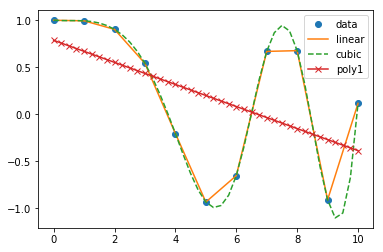

In [65]:
from scipy.interpolate import interp1d
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(0, 10, num=41, endpoint=True)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--', xnew, p(xnew), 'x-')
plt.legend(['data', 'linear', 'cubic', 'poly1'], loc='best')
plt.show()

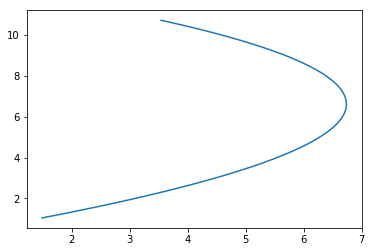

In [94]:
xs = [2,3,4,5,6,7,8,6,5,4,4]
ys = [1,2,3,4,5,6,7,8,9,10,11]
xs, ys = interp(xs, ys)
plt.plot(xs, ys)
plt.show()